# Experimenting with re-writing the model with PyMC3.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import emcee
import corner

import astropy.stats as aps
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates.builtin_frames.galactocentric \
    import get_matrix_vectors
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import aviary as av
import theano.tensor as tt

In [3]:
def deg_to_rad(deg):
    return deg * (2 * np.pi) / 360

# Solar coords
sun_xyz = [-8.122, 0, 0] * u.kpc
sun_vxyz = [12.9, 245.6, 7.78] * u.km/u.s

galcen_frame = coord.Galactocentric(galcen_distance=np.abs(sun_xyz[0]),
                                    galcen_v_sun=sun_vxyz,
                                    z_sun=0*u.pc)

# Pre-compute the rotation matrix to go from Galactocentric to ICRS
# (ra/dec) coordinates
R_gal, _ = get_matrix_vectors(galcen_frame, inverse=True)

ra_gc_deg, dec_gc_deg = 266.4051, -28.936175
ra_gc, dec_gc = deg_to_rad(np.array([ra_gc_deg, dec_gc_deg]))

eta_deg = 58.5986320306
eta = deg_to_rad(eta_deg)

d_gc = np.abs(sun_xyz[0]).value
zsun = 0

In [37]:
# Calculate prior parameters from vx, vy, vz distributions.
vels = pd.read_csv("../../data/gaia_lamost_mc_velocities.csv")
m = (vels.rv.values != 0) * np.isfinite(vels.rv.values) * (vels.parallax.values > 0) * np.isfinite(vels.parallax.values)
m &= np.isfinite(vels.basic_vx.values) * np.isfinite(vels.basic_vy.values) * np.isfinite(vels.basic_vz.values)
vels = vels.iloc[m]

# Calculate covariance between velocities
VX = np.stack((vels.basic_vx.values, vels.basic_vy.values,
               vels.basic_vz.values, np.log(1./vels.parallax.values)), axis=0)
mean = np.mean(VX, axis=1)
cov = np.cov(VX)

Matrix for calculating Galactocentric positions from equatorial coordinates.

In [5]:
def r_icrs_norm(ra_deg, dec_deg):
    ra, dec = deg_to_rad(np.array([ra_deg, dec_deg]))
    return np.array([[np.cos(ra) * np.cos(dec)],
                     [np.sin(ra) * np.cos(dec)],
                     [np.sin(dec)]])

def eqtogal(ra, dec, d):
    r = r_icrs_norm(ra, dec)
    R1 = np.array([[np.cos(dec_gc), 0, np.sin(dec_gc)],
                   [0, 1, 0],
                   [-np.sin(dec_gc), 0, np.cos(dec_gc)]])
    R2 = np.array([[np.cos(ra_gc), np.sin(ra_gc), 0],
                   [-np.sin(ra_gc), np.cos(ra_gc), 0],
                   [0, 0, 1]])
    R3 = np.array([[1, 0, 0],
                   [0, np.cos(eta), np.sin(eta)],
                   [0, -np.sin(eta), np.cos(eta)]])
    R1_R2 = np.dot(R1, R2)
    R = np.dot(R3, R1_R2)
    
    xhat = np.array([[1, 0, 0]]).T
    theta = np.arcsin(zsun/d_gc)
    H = np.array([[np.cos(theta), 0, np.sin(theta)],
                  [0, 1, 0],
                  [-np.sin(theta), 0, np.cos(theta)]])
    
    rdash = d * np.dot(R, r) - d_gc * xhat
    
    rgc = np.dot(H, rdash)
    return rgc

Code for converting km/s to mas/yr.

In [6]:
def cartesian_to_angular_no_units(km_s, kpc):
    to_km_yr = 365.2425 * 24*3600
    to_m_yr = 1000
    to_kpc_yr = 1./3.0856775814671917e+19
    to_rad_yr = 1./kpc
    to_deg_yr = 360/(2*np.pi)
    to_mas_yr = 3600*1000
    return np.arcsin((km_s * to_km_yr) * to_m_yr * to_kpc_yr * to_rad_yr) * to_deg_yr * to_mas_yr

In [7]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """

    # Precompute this matrix and save for each star.
    M = np.array([
        [-np.sin(ra), np.cos(ra), 0.],
        [-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)],
        [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    ])
    return M


def get_icrs_from_galactocentric(xyz, vxyz, ra, dec, distance):

    # Parameters

    dx = xyz - sun_xyz.value
    dv = vxyz - sun_vxyz.value

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = M @ R_gal @ dv
        
    # Calculate the unit conversion using 1kms/1km and transform.
    pm = cartesian_to_angular_no_units(proj_dv[:2], distance)

    rv = proj_dv[2]

    return pm, rv

In [8]:
def lnlike_one_star(params, pm, pm_err, pos, pos_err):

    # Unpack parameters and make distance linear.
    vx, vy, vz, lnD = params
    D = np.exp(lnD)

    xyz = eqtogal(pos[0], pos[1], D)

    # Calculate pm and rv from XYZ and V_XYZ
    vxyz = [vx, vy, vz]
    pm_from_v, rv_from_v = get_icrs_from_galactocentric(xyz[:, 0], vxyz, pos[0], pos[1], D)

    return -.5*(pm_from_v[0] - pm[0])**2/pm_err[0]**2 \
           -.5*(pm_from_v[1] - pm[1])**2/pm_err[1]**2 \
           -.5*(1./D - pos[2])**2/pos_err[2]**2


def multivariate_lngaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return -fac / 2 - np.log(N)


def lnprior(params):
    vx, vy, vz, lnD = params
    pos = np.stack((vx, vy, vz, lnD))
    return float(multivariate_lngaussian(pos, mean, cov))


def lnprob(params, pm, pm_err, pos, pos_err):
    return lnlike_one_star(params, pm, pm_err, pos, pos_err) + lnprior(params)

In [9]:
# Format parameter and data arrays.
df = vels.iloc[0]

pos = [df["ra"], df["dec"], df["parallax"]]
pos_err = [df["ra_error"], df["dec_error"], df["parallax_error"]]
proper = [df["pmra"], df["pmdec"]]
proper_err = [df["pmra_error"], df["pmdec_error"]]
inits = [df["basic_vx"], df["basic_vy"], df["basic_vz"],
         np.log(1./df["parallax"])]

In [60]:
from astropy.coordinates import SkyCoord

# Try a star with position at the galactic pole.
c = SkyCoord('12h51.4m', '+27.13',  unit=(u.hourangle, u.deg), frame='icrs')
pos[0] = c.ra.value
pos[1] = c.dec.value

In [61]:
M = get_tangent_basis(pos[0], pos[1])

Test lhf.

In [62]:
lnlike_one_star(inits, proper, proper_err, pos, pos_err)

-428772.31830829626

In [70]:
# Run MCMC.
ndim, nwalkers = 4, 16
p0 = np.random.randn(nwalkers, ndim)*1e-2 + inits
sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob,
                                args=(proper, proper_err, pos, pos_err))
sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprior)

nsteps = 1000
sampler.run_mcmc(p0, nsteps, progress=True);

# Extract inferred parameters and uncertainties.
flat_samples = sampler.get_chain(discard=int(nsteps/2), flat=True)
params_inferred = np.median(flat_samples, axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 817.60it/s]


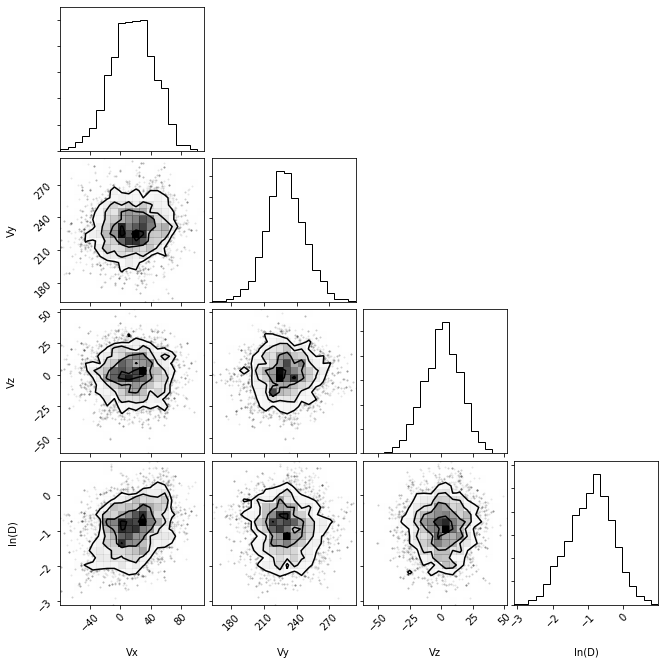

In [71]:
labels=["Vx", "Vy", "Vz", "ln(D)"]
fig = corner.corner(flat_samples, labels=labels);
fig.savefig("corner_prior")

Now try to rewrite this in PyMC3...

Write functions in theano.

In [72]:
import theano.tensor as tt

def tt_r_icrs_norm(ra_deg, dec_deg):
    ra, dec = deg_to_rad(np.array([ra_deg, dec_deg]))
    return np.array([[np.cos(ra) * np.cos(dec)],
                     [np.sin(ra) * np.cos(dec)],
                     [np.sin(dec)]])

def tt_eqtogal(ra, dec, d):
    r = tt_r_icrs_norm(ra, dec)
    R1 = np.array([[np.cos(dec_gc), 0, np.sin(dec_gc)],
                   [0, 1, 0],
                   [-np.sin(dec_gc), 0, np.cos(dec_gc)]])
    R2 = np.array([[np.cos(ra_gc), np.sin(ra_gc), 0],
                   [-np.sin(ra_gc), np.cos(ra_gc), 0],
                   [0, 0, 1]])
    R3 = np.array([[1, 0, 0],
                   [0, np.cos(eta), np.sin(eta)],
                   [0, -np.sin(eta), np.cos(eta)]])
    R1_R2 = np.dot(R1, R2)
    R = np.dot(R3, R1_R2)
    
    xhat = np.array([[1, 0, 0]]).T
    theta = np.arcsin(zsun/d_gc)
    H = np.array([[np.cos(theta), 0, np.sin(theta)],
                  [0, 1, 0],
                  [-np.sin(theta), 0, np.cos(theta)]])
    
    rdash = d * np.dot(R, r) - d_gc * xhat
    
    rgc = tt.dot(H, rdash)
    return rgc

def tt_cartesian_to_angular_no_units(km_s, kpc):
    to_km_yr = 365.2425 * 24*3600
    to_m_yr = 1000
    to_kpc_yr = 1./3.0856775814671917e+19
    to_rad_yr = 1./kpc
    to_deg_yr = 360/(2*np.pi)
    to_mas_yr = 3600*1000
    return tt.arcsin((km_s * to_km_yr) * to_m_yr * to_kpc_yr * to_rad_yr) * to_deg_yr * to_mas_yr

def tt_get_icrs_from_galactocentric(xyz, vxyz, ra, dec, distance):
    dx = xyz - sun_xyz.value
    dv = vxyz - sun_vxyz.value

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = tt.dot(M, tt.dot(R_gal, dv))
        
    # Calculate the unit conversion using 1kms/1km and transform.
    pm = tt_cartesian_to_angular_no_units(proj_dv[:2], distance)

    rv = proj_dv[2]

    return pm, rv

In [73]:
vxyz = tt.as_tensor_variable(np.array([10.0, 15.0, 250.0]))
D = tt.as_tensor_variable(1.23)
xyz = tt_eqtogal(pos[0], pos[1], D)

In [74]:
xyz.eval()

array([[-8.12217414e+00],
       [-6.87556752e-05],
       [ 1.22999999e+00]])

In [75]:
pm_from_v, rv_from_v = tt_get_icrs_from_galactocentric(xyz[:, 0], vxyz, pos[0], pos[1], D)

In [76]:
#     vx, vy, vz, lnD = params
#     pos = np.stack((vx, vy, vz, lnD))
#     return float(multivariate_lngaussian(pos, mean, cov))


In [77]:
import pymc3 as pm
import exoplanet as xo

with pm.Model() as model:
    
    vxyzD = pm.MvNormal("vxyzD", mu=mean, cov=cov, shape=4)
    vxyz = pm.Deterministic("vxyz", vxyzD[:3])
    log_D = pm.Deterministic("log_D", vxyzD[3])
    D = pm.Deterministic("D", tt.exp(log_D))
    
    xyz = pm.Deterministic("xyz", tt_eqtogal(pos[0], pos[1], D)[:, 0])
    
    pm_from_v, rv_from_v = tt_get_icrs_from_galactocentric(xyz, vxyz, pos[0], pos[1], D)
    
    pm.Normal("pm", mu=pm_from_v, sigma=np.array(proper_err), observed=np.array(proper))
    pm.Normal("parallax", mu=1. / D, sigma=pos_err[2], observed=pos[2])
    
    map_soln = xo.optimize()
    trace = pm.sample(tune=1500, draws=1000, start=map_soln, step=xo.get_dense_nuts_step(target_accept=0.9))

optimizing logp for variables: [vxyzD]
33it [00:00, 410.75it/s, logp=-7.576399e+00] 
message: Optimization terminated successfully.
logp: -93834.1247321358 -> -7.576399290817848
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:07<00:00, 1373.38draws/s]


In [83]:
samples = pm.trace_to_dataframe(trace)
print(np.shape(samples))
# corner.corner(samples[:, :4]);
print(np.shape())

(4000, 12)

In [ ]:

#     # Unpack parameters and make distance linear.
#     vx, vy, vz, lnD = params
#     D = np.exp(lnD)

#     xyz = eqtogal(pos[0], pos[1], D)

#     # Calculate pm and rv from XYZ and V_XYZ
#     vxyz = [vx, vy, vz]
#     pm_from_v, rv_from_v = get_icrs_from_galactocentric(xyz[:, 0], vxyz, pos[0], pos[1], D)

#     return -.5*(pm_from_v[0] - pm[0])**2/pm_err[0]**2 \
#            -.5*(pm_from_v[1] - pm[1])**2/pm_err[1]**2 \
#            -.5*(1./D - pos[2])**2/pos_err[2]**2



In [9]:
import theano.tensor as tt
from theano import function
from theano import pp

x = tt.dmatrix("x")
y = tt.dmatrix("y")
z = x + y
f = function([x, y], z)
f([[1, 2], [3, 4]], [[10, 20], [30, 40]])

array([[11., 22.],
       [33., 44.]])

Function for converting degrees to radians:

In [22]:
deg = tt.dscalar("deg")
deg2rad = deg * (2 * 3.14159265359) / 360
ra_rad_gc = deg2rad.eval({deg: ra_gc})
dec_rad_gc = deg2rad.eval({deg: dec_gc})

ra = deg2rad.eval({deg: ra_gc})
dec = deg2rad.eval({deg: dec_gc})
d = 1.

Define all matrix variables.

In [17]:
r_icrs = tt.dmatrix("r_icrs_mat")
R1 = tt.dmatrix("R1")
R2 = tt.dmatrix("R2")
R3 = tt.dmatrix("R3")
xhat = tt.dmatrix("xhat")
H = tt.dmatrix("H")
d_gc_tt = tt.dscalar("d_gc")
zsun_tt = tt.dscalar("zsun")

Now write the matrix operations in theano.

In [28]:
# frdash = Rr - d_gc_tt * xhat
# ftheta = tt.arcsin(zsun_tt/d_gc_tt)
# frgc = tt.dot(H, rdash)

And the theano maths operations.

In [21]:
theta = tt.dscalar("theta")
cos = tt.cos(theta)
sin = tt.sin(theta)

cd = cos.eval({theta: dec_rad_gc})
sd = sin.eval({theta: dec_rad_gc})
cr = cos.eval({theta: ra_rad_gc})
sr = sin.eval({theta: ra_rad_gc})

fR1R2 = tt.dot(R1, R2)
R1R2 = fR1R2.eval({R1: [[cd, 0, sd],
                        [0, 1, 0],
                        [-sd, 0, cd]],
                   R2: [[cr, sr, 0],
                        [-sr, cr, 0],
                        [0, 0, 1]]})

In [27]:
ce = cos.eval({theta: eta})
se = sin.eval({theta: eta})

fR = tt.dot(R3, R1R2)
R = fR.eval({R3: [[1, 0, 0],
                  [0, ce, se],
                  [0, -se, ce]],
             R1R2: R1R2})

TypeError: unhashable type: 'numpy.ndarray'

In [36]:
target = tt.as_tensor_variable(np.indices((3, 3)))
theta = eta
c, s = tt.cos(theta), tt.sin(theta)
R3 = tt.stack(1, 0, 0, 0, c, s, 0, -s, c).reshape((3,3))
target = tt.tensordot(rotate, target, axes=((0, 0)))

In [40]:
target = tt.as_tensor_variable(np.indices((2, 2)))
theta = eta
c, s = tt.cos(theta), tt.sin(theta)
R3 = tt.stack(c, s, -s, c).reshape((2,2))
target = tt.tensordot(rotate, target, axes=((0, 0)))

AsTensorError: ('Cannot convert 2 to TensorType', <class 'int'>)

In [ ]:
cd = cos.eval({theta: dec})
sd = sin.eval({theta: dec})
cr = cos.eval({theta: ra})
sr = sin.eval({theta: ra}) 

fRr = tt.dot(R, r_icrs)
Rr = fRr.eval({R: R1R2, r_icrs: 
            [[d * cr * cd],
             [d * sr * cd],
             [d * sd]]
            })

Now perform the operations on the matrices.

In [564]:
R1R2 = fR1R2.eval({R1:
                   [[cos_dec_gc, 0, sin_dec_gc],
                    [0, 1, 0],
                    [-sin_dec_gc, 0, cos_dec_gc]],
                   R2:
                   [[cos_ra_gc, sin_ra_gc, 0],
                    [-sin_ra_gc, cos_ra_gc, 0],
                    [0, 0, 1]]})

In [23]:
Rr = fRr.eval({R: R1R2, r_icrs: 
            [[d * np.cos(ra) * np.cos(dec)],
             [d * np.sin(ra) * np.cos(dec)],
             [d * np.sin(dec)]]
            })

NameError: name 'fR' is not defined

In [517]:
def r_icrs_tt(ra_deg, dec_deg, d):
    ra, dec = deg_to_rad_tt(np.array([ra_deg, dec_deg]))
    return [[d * np.cos(ra) * np.cos(dec)],
            [d * np.sin(ra) * np.cos(dec)],
            [d * np.sin(dec)]]
        
def eqtogal_tt(ra, dec, d):
    r = r_icrs_tt(ra, dec, d)
    R1 = np.array([[tt.cos(dec_gc), 0, tt.sin(dec_gc)],
          [0, 1, 0],
          [-tt.sin(dec_gc), 0, tt.cos(dec_gc)]])
    R2 = np.array([[tt.cos(ra_gc), tt.sin(ra_gc), 0],
          [-tt.sin(ra_gc), tt.cos(ra_gc), 0],
          [0, 0, 1]])
    R3 = np.array([[1, 0, 0],
          [0, tt.cos(eta), tt.sin(eta)],
          [0, -tt.sin(eta), tt.cos(eta)]])
    R1_R2 = tt.dot(R1, R2)
    R = tt.dot(R3, R1_R2)

    xhat = [[1], [0], [0]]
    R_r = tt.dot(R, r)
    rdash = R_r - d_gc * xhat
    
    theta = tt.arcsin(zsun/d_gc)
    H = np.array([[tt.cos(theta), 0, tt.sin(theta)],
         [0, 1, 0],
         [-tt.sin(theta), 0, tt.cos(theta)]])
    
    rgc = tt.dot(H, rdash)
    return rgc

print(eqtogal_tt(266.4051, -28.936175, 1))

AsTensorError: ('Cannot convert [[Elemwise{cos,no_inplace}.0 0 Elemwise{sin,no_inplace}.0]\n [0 1 0]\n [Elemwise{neg,no_inplace}.0 0 Elemwise{cos,no_inplace}.0]] to TensorType', <class 'numpy.ndarray'>)

In [518]:
# Set up constants and variables

ra, dec = df["ra"], df["dec"]

M = [[-tt.sin(ra), tt.cos(ra), 0.],
     [-tt.sin(dec)*tt.cos(ra), -tt.sin(dec)*tt.sin(ra), tt.cos(dec)],
     [tt.cos(dec)*np.cos(ra), tt.cos(dec)*tt.sin(ra), tt.sin(dec)]]
print(np.shape(M))

sun_xyz = [-8.122, 0, 0]
sun_vxyz = [12.9, 245.6, 7.78]

(3, 3)


In [ ]:
with pm.Model() as model:
        
    # Set up the parameters
    params = pm.MvNormal("params", mu=mean, cov=cov, shape=(4))
    
    # The model
    
    # Parameters
    dx = xyz - sun_xyz
    dv = vxyz - sun_vxyz

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    MR = tt.dot(M, R_gal)
    proj_dv = tt.dot(MR, dv)
    
    # Calculate the unit conversion using 1kms/1km and transform.    
    pm_from_v = cartesian_to_angular_no_units(proj_dv[:2], distance)
    rv = proj_dv[2]
    
    return -.5*(pm_from_v[0] - pm[0])**2/pm_err[0]**2 \
           -.5*(pm_from_v[1] - pm[1])**2/pm_err[1]**2 \
           -.5*(1./D - pos[2])**2/pos_err[2]**2
    
    # Likelihood
    pm.Normal("parallax_obs", mu=mu, sigma=np.array(df.parallax_error),
              observed=np.array(df.parallax_mas))
    
    simple_trace = pm.sample(tune=5000, draws=5000)